# Favorita: Favorita Grocery Sales Forecasting

## Data Loading and Inspection  
For each data file, I want to see:  
(1) some samples with display(df.head(5)) or display(df.tail(5))  
(2) A summary of this DataFrame with df.describe()  
(3) Data types with print(df.dtypes)  
(4) Check if there is missing data with df.isnull().any().values  
(5) The number of unique values for each variable with display(df['column_name'].unique())

In [1]:
# Import libraries necessary for this project
import os.path
import pickle
import numpy as np
import pandas as pd
from sklearn.model_selection import ShuffleSplit
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

# Pretty display for notebooks
%matplotlib inline
# Loaddata() function is used to load two large csv files: train.csv and test.csv
def loaddata(filename, nrows=None):
    types = {'date':'string_', 'item_nbr': 'int32', 'store_nbr': 'int16', 'unit_sales': 'float32', 'onpromotion': np.dtype('O'),}
    data = pd.read_csv(filename, index_col='id', parse_dates=['date'], dtype=types, infer_datetime_format=True)
    return data

### 1. Train.csv  
There are 125497040 items in this training data with 6 variables each.  
6 variables include:  
1. id: This is meaningless for model training, and will be dropped
2. date: From 2013-01-01 to 2017-08-15
3. store_nbr: conintunous integer from 1 to 54
4. item_nbr: item id, un-continuous integers
5. unit_sale: continuous float number with min=-0.000153 max=89440
6. onpromotion: bool 0 1, and missing entries  

Missing entries only exist in the column 'onpromotion'.

In [2]:
# Load the training dataset
train_data = loaddata('input/train.csv')
print("Training dataset has {} data points with {} variables each.".format(*train_data.shape))

/home/adou/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Training dataset has 125497040 data points with 5 variables each.


In [3]:
display(train_data.describe())

,store_nbr,item_nbr,unit_sales
count,1.254970e+08,1.254970e+08,1.254970e+08
mean,2.746458e+01,9.727692e+05,5.319669e+00
std,1.633051e+01,5.205336e+05,2.306714e+01
min,1.000000e+00,9.699500e+04,-1.537200e+04
25%,1.200000e+01,5.223830e+05,2.000000e+00
50%,2.800000e+01,9.595000e+05,4.000000e+00
75%,4.300000e+01,1.354380e+06,9.000000e+00
max,5.400000e+01,2.127114e+06,8.944000e+04


In [4]:
print(train_data.dtypes)

date           datetime64[ns]
store_nbr               int16
item_nbr                int32
unit_sales            float32
onpromotion            object
dtype: object


In [5]:
for col in train_data.columns:
    print(col, train_data[col].unique(), sep='\n')

date
['2013-01-01T00:00:00.000000000' '2013-01-02T00:00:00.000000000'
 '2013-01-03T00:00:00.000000000' ..., '2017-08-13T00:00:00.000000000'
 '2017-08-14T00:00:00.000000000' '2017-08-15T00:00:00.000000000']
store_nbr
[25  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 23 24 26 27 28
 30 31 32 33 34 35 37 38 39 40 41 43 44 45 46 47 48 49 50 51 54 36 53 20 29
 21 42 22 52]
item_nbr
[ 103665  105574  105575 ..., 2126944 2123839 2011451]
unit_sales
[   7.            1.            2.         ...,  247.42999268  225.19599915
  114.91699982]
onpromotion
[nan 'False' 'True']


In [6]:
print("Nulls in train columns: {} => {}".format(train_data.columns.values, train_data.isnull().any().values))

Nulls in train columns: ['date' 'store_nbr' 'item_nbr' 'unit_sales' 'onpromotion'] => [False False False False  True]


### 2. holidays_events.csv  
There are 350 items in holidays_events with 6 variables each.  
Variables are listed below:
1. date: 312 unique dates from 2012-03-02 to 2017-12-26
2. type: ['Holiday', 'Transfer', 'Additional', 'Bridge', 'Work Day', 'Event']
3. locale: ['Local', 'Regional', 'National']
4. locale_name: ['Manta', 'Cotopaxi', 'Cuenca', 'Libertad', 'Riobamba', 'Puyo','Guaranda', 'Imbabura', 'Latacunga', 'Machala', 'Santo Domingo','El Carmen', 'Cayambe', 'Esmeraldas', 'Ecuador', 'Ambato', 'Ibarra','Quevedo', 'Santo Domingo de los Tsachilas', 'Santa Elena', 'Quito','Loja', 'Salinas', 'Guayaquil']
5. description:103 entries (don't understand)
6. transferred: [False,  True]  

There is no missing entries in this dataset.

In [7]:
holidays_events = pd.read_csv("input/holidays_events.csv")
print("Holidays_events has {} data points with {} variables each.".format(*holidays_events.shape))

display(holidays_events.describe())
print(holidays_events.dtypes)

print("Nulls in holidays columns: {} => {}".format(holidays_events.columns.values, holidays_events.isnull().any().values))


for col in holidays_events.columns:
    print(col, holidays_events[col].unique(), sep='\n')

Holidays_events has 350 data points with 6 variables each.


,date,type,locale,locale_name,description,transferred
count,350,350,350,350,350,350
unique,312,6,3,24,103,2
top,2014-06-25,Holiday,National,Ecuador,Carnaval,False
freq,4,221,174,174,10,338


date           object
type           object
locale         object
locale_name    object
description    object
transferred      bool
dtype: object
Nulls in holidays columns: ['date' 'type' 'locale' 'locale_name' 'description' 'transferred'] => [False False False False False False]
date
['2012-03-02' '2012-04-01' '2012-04-12' '2012-04-14' '2012-04-21'
 '2012-05-12' '2012-06-23' '2012-06-25' '2012-07-03' '2012-07-23'
 '2012-08-05' '2012-08-10' '2012-08-15' '2012-08-24' '2012-09-28'
 '2012-10-07' '2012-10-09' '2012-10-12' '2012-11-02' '2012-11-03'
 '2012-11-06' '2012-11-07' '2012-11-10' '2012-11-11' '2012-11-12'
 '2012-12-05' '2012-12-06' '2012-12-08' '2012-12-21' '2012-12-22'
 '2012-12-23' '2012-12-24' '2012-12-25' '2012-12-26' '2012-12-31'
 '2013-01-01' '2013-01-05' '2013-01-12' '2013-02-11' '2013-02-12'
 '2013-03-02' '2013-04-01' '2013-04-12' '2013-04-14' '2013-04-21'
 '2013-04-29' '2013-05-01' '2013-05-11' '2013-05-12' '2013-05-24'
 '2013-06-23' '2013-06-25' '2013-07-03' '2013-07-23' '

### 3. stores.csv  
There are 54 items in holidays_events with 5 variables each.  
Variables are listed below:
1. store_nbr: [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54]
2. city: ['Quito', 'Santo Domingo', 'Cayambe', 'Latacunga', 'Riobamba', 'Ibarra', 'Guaranda', 'Puyo', 'Ambato', 'Guayaquil', 'Salinas', 'Daule', 'Babahoyo', 'Quevedo', 'Playas', 'Libertad', 'Cuenca', 'Loja', 'Machala', 'Esmeraldas', 'Manta', 'El Carmen']
3. state: ['Pichincha', 'Santo Domingo de los Tsachilas', 'Cotopaxi', 'Chimborazo', 'Imbabura', 'Bolivar', 'Pastaza', 'Tungurahua', 'Guayas', 'Santa Elena', 'Los Rios', 'Azuay', 'Loja', 'El Oro', 'Esmeraldas', 'Manabi']
4. type: ['D', 'B', 'C', 'E', 'A']
5. cluster: [13,  8,  9,  4,  6, 15,  7,  3, 12, 16,  1, 10,  2,  5, 11, 14, 17]

There is no missing entries in this dataset.

In [8]:
stores = pd.read_csv("input/stores.csv")
print("Stores has {} data points with {} variables each.".format(*stores.shape))

display(stores.describe())
print(stores.dtypes)

for col in stores.columns:
    print(col, stores[col].unique(), sep='\n')

print("Nulls in stores columns: {} => {}".format(stores.columns.values, stores.isnull().any().values))


Stores has 54 data points with 5 variables each.


,store_nbr,cluster
count,54.000000,54.000000
mean,27.500000,8.481481
std,15.732133,4.693395
min,1.000000,1.000000
25%,14.250000,4.000000
50%,27.500000,8.500000
75%,40.750000,13.000000
max,54.000000,17.000000


store_nbr     int64
city         object
state        object
type         object
cluster       int64
dtype: object
store_nbr
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50
 51 52 53 54]
city
['Quito' 'Santo Domingo' 'Cayambe' 'Latacunga' 'Riobamba' 'Ibarra'
 'Guaranda' 'Puyo' 'Ambato' 'Guayaquil' 'Salinas' 'Daule' 'Babahoyo'
 'Quevedo' 'Playas' 'Libertad' 'Cuenca' 'Loja' 'Machala' 'Esmeraldas'
 'Manta' 'El Carmen']
state
['Pichincha' 'Santo Domingo de los Tsachilas' 'Cotopaxi' 'Chimborazo'
 'Imbabura' 'Bolivar' 'Pastaza' 'Tungurahua' 'Guayas' 'Santa Elena'
 'Los Rios' 'Azuay' 'Loja' 'El Oro' 'Esmeraldas' 'Manabi']
type
['D' 'B' 'C' 'E' 'A']
cluster
[13  8  9  4  6 15  7  3 12 16  1 10  2  5 11 14 17]
Nulls in stores columns: ['store_nbr' 'city' 'state' 'type' 'cluster'] => [False False False False False]


### 4. oil.csv  
There are 1218 items in holidays_events with 2 variables each.  
Variables are listed below:
1. date: from 2013-01-01 to 2017-08-31
2. dcoilwtico: continuous value from 26.19~110.62

There is 1 missing entries in this dataset.

In [9]:
oil = pd.read_csv("input/oil.csv")
print("Oil has {} data points with {} variables each.".format(*oil.shape))

display(oil.describe())
print(oil.dtypes)

for col in oil.columns:
    print(col, oil[col].unique(), sep='\n')

print("Nulls in oil columns: {} => {}".format(oil.columns.values, oil.isnull().any().values))

Oil has 1218 data points with 2 variables each.


,dcoilwtico
count,1175.000000
mean,67.714366
std,25.630476
min,26.190000
25%,46.405000
50%,53.190000
75%,95.660000
max,110.620000


date           object
dcoilwtico    float64
dtype: object
date
['2013-01-01' '2013-01-02' '2013-01-03' ..., '2017-08-29' '2017-08-30'
 '2017-08-31']
dcoilwtico
[    nan   93.14   92.97   93.12   93.2    93.21   93.08   93.81   93.6
   94.27   93.26   94.28   95.49   95.61   96.09   95.06   95.35   95.15
   95.95   97.62   97.98   97.65   97.46   96.21   96.68   96.44   95.84
   95.71   97.01   97.48   97.03   97.3    96.69   94.92   92.79   92.74
   92.63   92.84   92.03   90.71   90.13   90.88   90.47   91.53   92.01
   92.07   92.44   92.47   93.03   93.49   93.71   92.46   93.41   94.55
   95.99   96.53   97.24   97.1    97.23   95.02   92.76   93.36   94.18
   94.59   93.44   91.23   88.75   88.73   86.65   87.83   88.04   88.81
   89.21   91.07   93.27   94.09   93.22   90.74   93.7    95.25   95.8
   95.28   96.24   95.81   94.76   93.96   93.95   94.85   95.72   96.29
   95.55   93.98   94.12   93.84   94.65   93.13   93.57   91.93   93.66
   94.71   96.11   95.82   95.5    95.9

### 5. transactions.csv

There are 83488 items in holidays_events with 3 variables each.  
Variables are listed below:
1. date: from 2013-01-01 to 2017-08-15
2. store_nbr: 54 store numbers
2. transactions: integers between 5 and 8358

There is 1 missing entries in this dataset.

In [10]:
transactions = pd.read_csv("input/transactions.csv")
print("transactions has {} data points with {} variables each.".format(*transactions.shape))

display(transactions.describe())
print(transactions.dtypes)

for col in transactions.columns:
    print(col, transactions[col].unique(), sep='\n')

print("Nulls in transactions columns: {} => {}".format(transactions.columns.values, transactions.isnull().any().values))

transactions has 83488 data points with 3 variables each.


,store_nbr,transactions
count,83488.000000,83488.000000
mean,26.939237,1694.602158
std,15.608204,963.286644
min,1.000000,5.000000
25%,13.000000,1046.000000
50%,27.000000,1393.000000
75%,40.000000,2079.000000
max,54.000000,8359.000000


date            object
store_nbr        int64
transactions     int64
dtype: object
date
['2013-01-01' '2013-01-02' '2013-01-03' ..., '2017-08-13' '2017-08-14'
 '2017-08-15']
store_nbr
[25  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 23 24 26 27 28
 30 31 32 33 34 35 37 38 39 40 41 43 44 45 46 47 48 49 50 51 54 36 53 20 29
 21 42 22 52]
transactions
[ 770 2111 2358 ..., 4553 4400 4392]
Nulls in transactions columns: ['date' 'store_nbr' 'transactions'] => [False False False]


### 6. items.csv  
There are 4100 items in holidays_events with 4 variables each.  
Variables are listed below:
1. item_nbr: 4100 discrete values
2. family: ['GROCERY I' 'CLEANING' 'BREAD/BAKERY' 'DELI' 'POULTRY' 'EGGS'
 'PERSONAL CARE' 'LINGERIE' 'BEVERAGES' 'AUTOMOTIVE' 'DAIRY' 'GROCERY II'
 'MEATS' 'FROZEN FOODS' 'HOME APPLIANCES' 'SEAFOOD' 'PREPARED FOODS'
 'LIQUOR,WINE,BEER' 'BEAUTY' 'HARDWARE' 'LAWN AND GARDEN' 'PRODUCE'
 'HOME AND KITCHEN II' 'HOME AND KITCHEN I' 'MAGAZINES' 'HOME CARE'
 'PET SUPPLIES' 'BABY CARE' 'SCHOOL AND OFFICE SUPPLIES'
 'PLAYERS AND ELECTRONICS' 'CELEBRATION' 'LADIESWEAR' 'BOOKS']
3. class: 337 discrete values
4. perishable: 0 and 1
There is no missing entries in this dataset.

In [11]:
items = pd.read_csv("input/items.csv")
print("items has {} data points with {} variables each.".format(*items.shape))

display(items.describe())
print(items.dtypes)

for col in items.columns:
    print(col, items[col].unique(), sep='\n')

print("Nulls in items columns: {} => {}".format(items.columns.values, items.isnull().any().values))

items has 4100 data points with 4 variables each.


,item_nbr,class,perishable
count,4.100000e+03,4100.0000,4100.000000
mean,1.251436e+06,2169.6500,0.240488
std,5.876872e+05,1484.9109,0.427432
min,9.699500e+04,1002.0000,0.000000
25%,8.181108e+05,1068.0000,0.000000
50%,1.306198e+06,2004.0000,0.000000
75%,1.904918e+06,2990.5000,0.000000
max,2.134244e+06,7780.0000,1.000000


item_nbr       int64
family        object
class          int64
perishable     int64
dtype: object
item_nbr
[  96995   99197  103501 ..., 2132957 2134058 2134244]
family
['GROCERY I' 'CLEANING' 'BREAD/BAKERY' 'DELI' 'POULTRY' 'EGGS'
 'PERSONAL CARE' 'LINGERIE' 'BEVERAGES' 'AUTOMOTIVE' 'DAIRY' 'GROCERY II'
 'MEATS' 'FROZEN FOODS' 'HOME APPLIANCES' 'SEAFOOD' 'PREPARED FOODS'
 'LIQUOR,WINE,BEER' 'BEAUTY' 'HARDWARE' 'LAWN AND GARDEN' 'PRODUCE'
 'HOME AND KITCHEN II' 'HOME AND KITCHEN I' 'MAGAZINES' 'HOME CARE'
 'PET SUPPLIES' 'BABY CARE' 'SCHOOL AND OFFICE SUPPLIES'
 'PLAYERS AND ELECTRONICS' 'CELEBRATION' 'LADIESWEAR' 'BOOKS']
class
[1093 1067 3008 1028 2712 1045 1034 1044 1092 1032 1030 1075 2636 2644 3044
 1004 2416 2502 1062 3024 1072 1016 4126 3034 1014 1040 1084 7034 1056 3090
 3026 1042 1122 6810 2124 3020 2114 1026 2112 1096 2704 2708 1013 3038 1048
 2116 3032 1124 1066 2718 1236 1080 3004 1058 6824 1136 3016 1006 2302 1010
 2632 2226 2412 1078 1074 1036 3046 3022 3018 1035 2104 108

### test.csv

In [12]:
test_data = pd.read_csv("input/test.csv")
print("Favorita grocery sales forecasting testing data has {} samples with {} features each.".format(*test_data.shape))
display(test_data.head(5))

Favorita grocery sales forecasting testing data has 3370464 samples with 5 features each.


,id,date,store_nbr,item_nbr,onpromotion
0,125497040,2017-08-16,1,96995,False
1,125497041,2017-08-16,1,99197,False
2,125497042,2017-08-16,1,103501,False
3,125497043,2017-08-16,1,103520,False
4,125497044,2017-08-16,1,103665,False


### sample_submission.csv

In [13]:
sample_submission = pd.read_csv("input/sample_submission.csv")
display(sample_submission.head(n=5))
sample_submission.dtypes

,id,unit_sales
0,125497040,0
1,125497041,0
2,125497042,0
3,125497043,0
4,125497044,0


id            int64
unit_sales    int64
dtype: object

# Data Exploration

In [14]:
date_mask = (train_data['date'] >= '2016-08-28') & (train_data['date']<= '2016-08-31')
train = train_data[date_mask]
print(train.shape)
max_date = train['date'].max()
min_date = train['date'].min()
days = (max_date - min_date).days + 1
print(days)

print(oil.columns.values)

(379872, 5)
4
['date' 'dcoilwtico']


## oil

In [15]:
import plotly.graph_objs as go
import plotly.offline as py
py.init_notebook_mode(connected=True)

trace = go.Scatter(name='Oil prices', x=oil['date'], y=oil['dcoilwtico'], 
                   mode='lines', line=dict(color='rgb(20, 15, 200, 0.8)'), 
                   fillcolor='rgba(0,0, 216, 0.3)', fill='tonexty')
data = go.Data([trace])
layout = go.Layout(yaxis=dict(title='Daily Oil price'), 
                  title='Daily oil prices from Jan 2013 till Auguest 2017',
                  showlegend = False )
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='pandas-time-series-error-bars')

Picture talk:  
The oil price was stable from Jan 2013 to July 2014, then had a sudden drop at the end of 2014, which matched the crude oil price trend (https://www.eia.gov/todayinenergy/detail.php?id=19451) Since Jan 2015, oil price stablizes around 50, about half of the price before July 2014.

## stores

Text(0,0.5,'Store number')

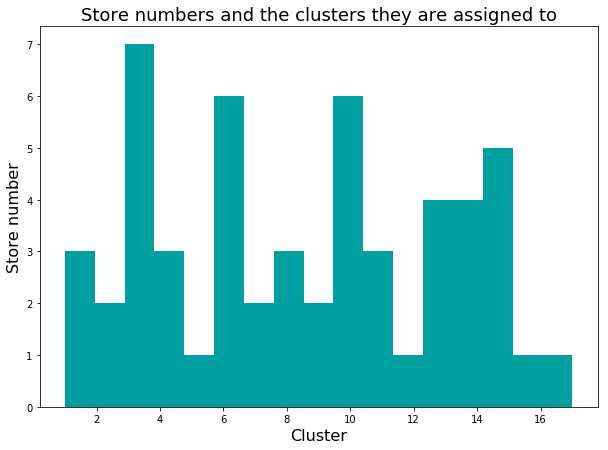

In [16]:
fig = plt.figure(figsize=(10, 7))

plt.hist(stores['cluster'], color = '#00A0A0', bins=stores['cluster'].nunique())
plt.title('Store numbers and the clusters they are assigned to', fontsize=18)
plt.xlabel('Cluster', fontsize=16)
plt.ylabel('Store number', fontsize=16)
# print(stores['cluster'].value_counts())

# # An alternative to plot bar figure
# fig2 = plt.figure(figsize=(10, 7))
# hist = stores['cluster'].value_counts(sort=False).values
# bins = stores['cluster'].value_counts(sort=False).index
# plt.bar(bins, hist)

## heatmap of store numbers and the clusters they are assigned to

# plt.figure(figsize=(15,12))
# store_pivot = stores.dropna().pivot("store_nbr", "cluster", "store_nbr")
# ax = sns.heatmap(store_pivot, cmap='jet', annot=True, linewidths=0, linecolor='white')
# plt.title('Store numbers and the clusters they are assigned to')

Picture talk:  
Some clusters have less number of stores, such as 5, 12, 16, 17 only have 1 store, while some clusters have more number of stores, for example cluster 3 has 7 stores, cluster 6 and 10 have 6 stores each.

Text(0.5,0,'Store type')

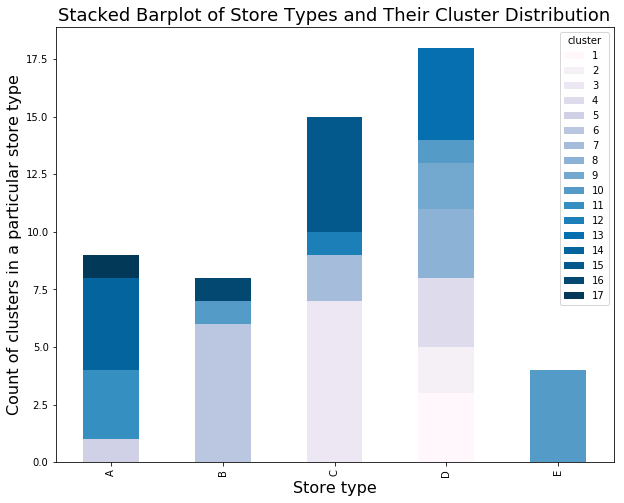

In [17]:
type_cluster = stores.groupby(['type', 'cluster']).size()
type_cluster.unstack().plot(kind='bar', stacked=True, colormap='PuBu', figsize=(10,8), grid=False)
plt.title('Stacked Barplot of Store Types and Their Cluster Distribution', fontsize=18)
plt.ylabel('Count of clusters in a particular store type', fontsize=16)
plt.xlabel('Store type', fontsize=16)

Picture talks:  
Type E contains only one cluster of stores. All other types contain mixed clusters of stores. It looks like there is no obvious relationship between store type and clusters.

Text(0,0.5,'Count of stores for a particular city')

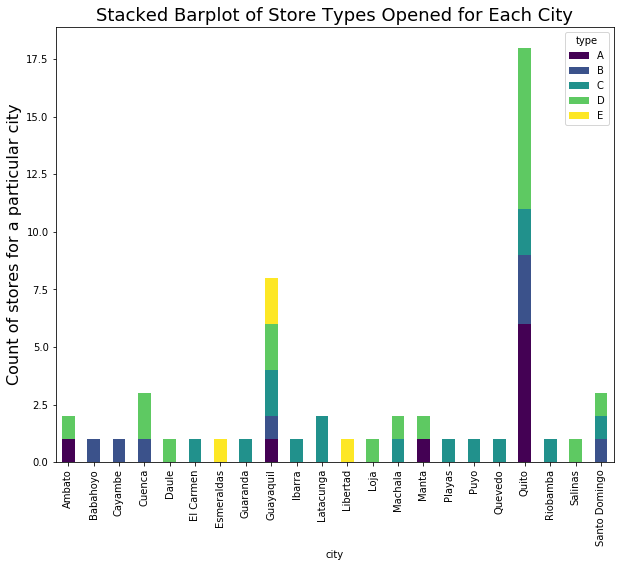

In [18]:
city_type = stores.groupby(['city', 'type']).store_nbr.size()
city_type.unstack().plot(kind='bar', stacked=True, colormap='viridis', figsize=(10,8), grid=False)
plt.title('Stacked Barplot of Store Types Opened for Each City', fontsize=18)
plt.ylabel('Count of stores for a particular city', fontsize=16)

Picture talks:  
More than half of cities have only one type of stores. Two cities standout in terms of variety of store types are Guayaquil and Quito. This can be easily explained that Guayaquil is the largest and most populous city in Ecuador, and Quito is its capital city.

## Holidays

## Transactions

Text(0.5,0,'Date')

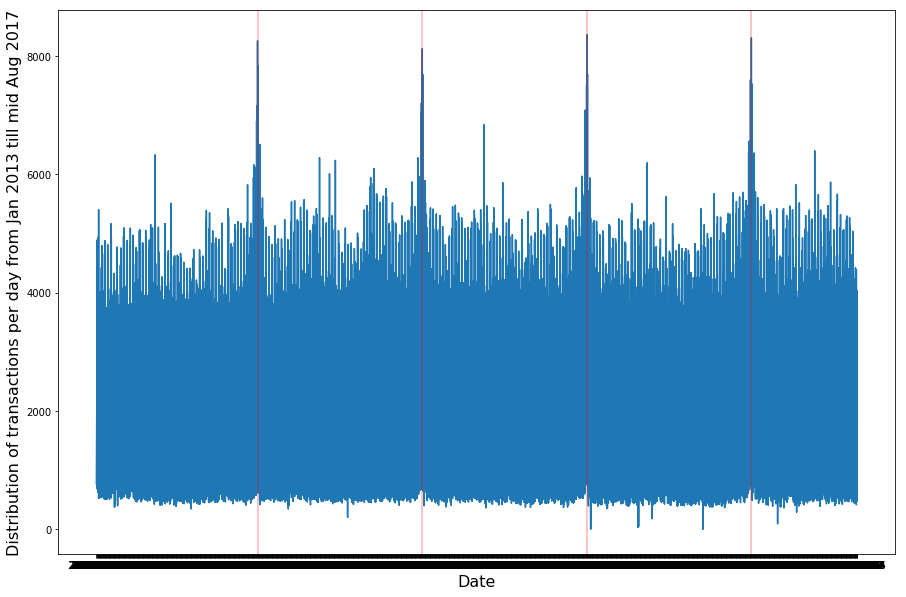

In [19]:
plt.figure(figsize=(15,10))
plt.plot(transactions.date.values, transactions.transactions.values)
plt.axvline(x='2013-12-23', color='red', alpha=0.3)
plt.axvline(x='2014-12-23', color='red', alpha=0.3)
plt.axvline(x='2015-12-23', color='red', alpha=0.3)
plt.axvline(x='2016-12-23', color='red', alpha=0.3)
plt.ylabel('Distribution of transactions per day from Jan 2013 till mid Aug 2017' , fontsize=16)
plt.xlabel('Date', fontsize=16)

Picture talks:  
There is an obvious peak during Christmas.

## Items

In [20]:
trace2 = go.Bar(
    y=items.family.value_counts().values, 
    x=items.family.value_counts().index, 
    marker=dict(
        color=items.family.value_counts().values, 
        colorscale='Portland', 
        reversescale = False), 
    orientation='v',)

data = go.Data([trace2])
layout = dict(title='Counts of items per family category', 
              width = 800, height=800, 
              yaxis = dict(showgrid=False, showline=False, showticklabels=True,))

fig1=go.Figure(data=data, layout=layout)
py.iplot(fig1, filename='plots')

In [21]:
trace3 = go.Bar(
    y=items['class'].value_counts().values, 
    x=items['class'].value_counts().index, 
    marker=dict(
        color=items['class'].value_counts().values, 
        colorscale='Portland', 
        reversescale = False), 
    orientation='v',)

data = go.Data([trace3])
layout = dict(title='Counts of items per class', 
              width = 800, height=800, 
              yaxis = dict(showgrid=False, showline=False, showticklabels=True,))

fig3=go.Figure(data=data, layout=layout)
py.iplot(fig3, filename='plots')

In [22]:
# class_family = items.groupby(['class','family']).size()
# class_family.unstack().plot(kind='bar', stacked=True, colormap='coolwarm', figsize=(12,10), grid=False)
# plt.title('Stacked Barplot of class in each family', fontsize=18)
# plt.ylabel('Count of entries')

Text(0,0.5,'Count of entries')

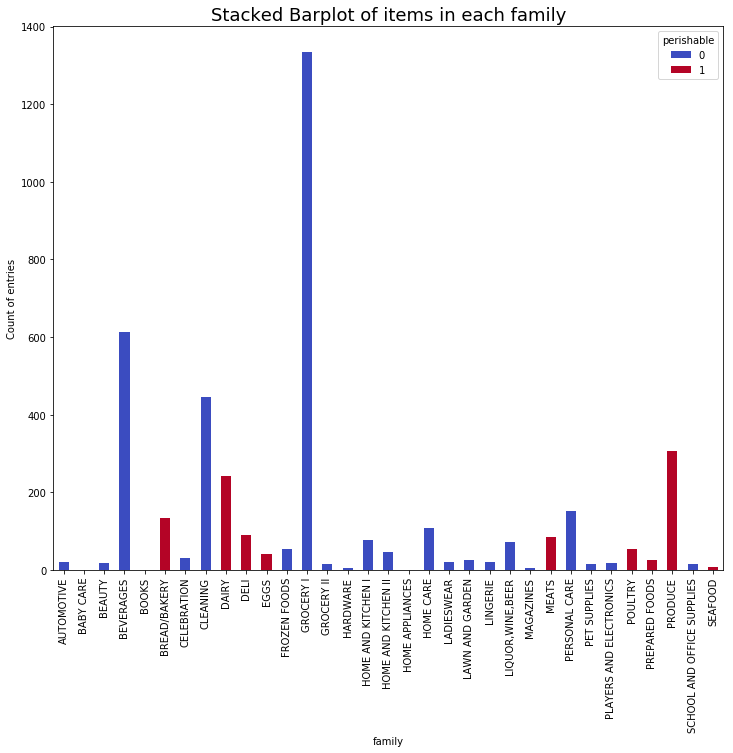

In [23]:
fam_perishable = items.groupby(['family', 'perishable']).size()
fam_perishable.unstack().plot(kind='bar', stacked=True, colormap='coolwarm', figsize=(12,10), grid=False)
plt.title('Stacked Barplot of items in each family', fontsize=18)
plt.ylabel('Count of entries')

Picture talks:  
Perishable is heavily correlated with family. A coorelation scatter plot?

Text(0,0.5,'Count of entries')

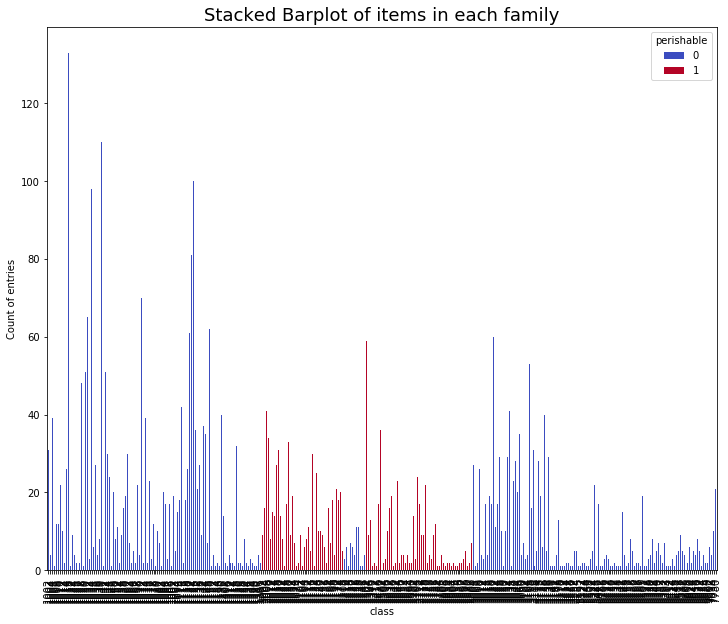

In [24]:
fam_perishable = items.groupby(['class', 'perishable']).size()
fam_perishable.unstack().plot(kind='bar', stacked=True, colormap='coolwarm', figsize=(12,10), grid=False)
plt.title('Stacked Barplot of items in each family', fontsize=18)
plt.ylabel('Count of entries')

Picture talks:  
Perishable items gather together in the middle part of the class. Can I find out the range of the class number?